# 📊 Xử lý dữ liệu và Feature Engineering

## Mục tiêu
- Chuyển đổi dữ liệu từ file NetCDF (.nc) sang CSV
- Làm sạch và tiền xử lý dữ liệu
- Tạo các đặc trưng mới (Feature Engineering)
- Chuẩn bị dữ liệu cho mô hình học máy

## Các bước thực hiện
1. Chuyển đổi file NetCDF sang CSV
2. Hợp nhất các file dữ liệu
3. Xử lý và tính toán lượng mưa theo giờ
4. Tạo các đặc trưng liên quan đến mưa
5. Đổi tên và làm sạch dữ liệu
6. Phân tích tương quan giữa các đặc trưng

---

## 1. Chuyển đổi file NetCDF sang CSV

In [ ]:
# Import thư viện cần thiết
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def convert_nc_to_csv(input_file, output_file, lat=18.68, lon=105.68):
    """
    Chuyển đổi file NetCDF sang CSV với các đơn vị chuẩn.
    
    Parameters:
    -----------
    input_file : str - Đường dẫn file NetCDF
    output_file : str - Đường dẫn file CSV đầu ra
    lat : float - Vĩ độ điểm cần lấy dữ liệu
    lon : float - Kinh độ điểm cần lấy dữ liệu
    """
    # Bước 1: Đọc file NetCDF
    ds = xr.open_dataset(input_file)
    
    # Bước 2: Kiểm tra tọa độ
    print("📍 Tọa độ trong tệp:")
    print(f"   Latitude: {ds['latitude'].values}")
    print(f"   Longitude: {ds['longitude'].values}")
    
    # Bước 3: Lấy dữ liệu cho điểm gần nhất
    ds_point = ds.sel(latitude=lat, longitude=lon, method='nearest')
    
    # Bước 4: Chuyển đổi đơn vị
    rainfall = ds_point['tp'] * 1000              # m -> mm
    soil_moisture = ds_point['swvl1'] * 100       # m³/m³ -> %
    temperature = ds_point['t2m'] - 273.15        # K -> °C
    surface_pressure = ds_point['sp'] / 100       # Pa -> hPa
    dewpoint = ds_point['d2m'] - 273.15           # K -> °C
    
    # Tính độ ẩm tương đối (công thức Magnus)
    relative_humidity = 100 * (
        np.exp((17.625 * dewpoint) / (243.04 + dewpoint)) / 
        np.exp((17.625 * temperature) / (243.04 + temperature))
    )
    
    # Bước 5: Tạo Dataset mới
    processed_ds = xr.Dataset({
        'rainfall_mm': rainfall,
        'soil_moisture_percent': soil_moisture,
        'temperature_celsius': temperature,
        'surface_pressure_hpa': surface_pressure,
        'relative_humidity_percent': relative_humidity
    })
    
    # Bước 6: Chuyển thành DataFrame và lưu
    df = processed_ds.to_dataframe().reset_index()
    df.to_csv(output_file, index=False)
    print(f"✅ Dữ liệu đã được lưu vào {output_file}")
    
    return df

# Sử dụng hàm để chuyển đổi
df = convert_nc_to_csv('24august.nc', '24august_processed.csv')

Tọa độ trong tệp:
Latitude: [19.8 19.7 19.6 19.5 19.4 19.3 19.2 19.1 19.  18.9 18.8 18.7 18.6]
Longitude: [104.  104.1 104.2 104.3 104.4 104.5 104.6 104.7 104.8 104.9 105.  105.1
 105.2 105.3 105.4 105.5 105.6 105.7 105.8]
Dữ liệu đã được lưu vào 24august_processed.csv


---

## 2. Hợp nhất các file CSV

In [ ]:
import pandas as pd

def merge_csv_files(file_list, output_file):
    """
    Hợp nhất nhiều file CSV thành một file duy nhất.
    
    Parameters:
    -----------
    file_list : list - Danh sách các file CSV cần hợp nhất
    output_file : str - Đường dẫn file CSV đầu ra
    """
    dfs = [pd.read_csv(f) for f in file_list]
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False)
    print(f"✅ Đã hợp nhất {len(file_list)} file, lưu vào {output_file}")
    return merged_df

# Danh sách các file cần hợp nhất
file_list = [
    '6_processed.csv',
    '7_processed.csv',
    '8_processed.csv',
    '9_processed.csv',
    '10_processed.csv',
    '11_processed.csv'
]

# Hợp nhất các file
merged_df = merge_csv_files(file_list, '24all_processed.csv')

Đã hợp nhất xong, lưu vào all_processed.csv


---

## 3. Giải thích đơn vị dữ liệu

| Biến | Đơn vị gốc | Đơn vị sau chuyển đổi | Mô tả |
|------|------------|----------------------|-------|
| `rainfall_mm` | m | mm | Lượng mưa tích lũy từ 00:00 |
| `soil_moisture_percent` | m³/m³ | % | Độ ẩm đất |
| `temperature_celsius` | K | °C | Nhiệt độ không khí |
| `surface_pressure_hpa` | Pa | hPa | Áp suất không khí |
| `relative_humidity_percent` | - | % | Độ ẩm tương đối (tính từ nhiệt độ điểm sương)

---

## 4. Tính toán lượng mưa theo giờ

### Logic tính toán:
- **Giờ 00:00**: Lấy hiệu giữa giá trị hiện tại và 23:00 ngày trước
- **Giờ 01:00**: Giữ nguyên giá trị gốc (bắt đầu ngày mới)
- **Các giờ khác**: Tính hiệu so với giờ trước trong cùng ngày

In [ ]:
import seaborn as sns
import pandas as pd

def calculate_hourly_rain(df):
    """
    Tính lượng mưa theo giờ từ dữ liệu mưa tích lũy.
    
    Parameters:
    -----------
    df : DataFrame - DataFrame chứa cột 'rainfall_mm' và 'valid_time'
    
    Returns:
    --------
    DataFrame với cột 'rain_hourly' được thêm vào
    """
    # Xóa các cột không cần thiết
    df = df.drop(['number', 'latitude', 'longitude', 'expver'], axis=1)
    
    # Xử lý thời gian
    df = df.sort_values('valid_time').reset_index(drop=True)
    df['valid_time'] = pd.to_datetime(df['valid_time'], errors='coerce')
    df['hour'] = df['valid_time'].dt.hour
    df['date'] = df['valid_time'].dt.date
    
    # Tạo cột rain_hourly với giá trị NaN ban đầu
    df['rain_hourly'] = pd.NA
    
    for i in range(len(df)):
        if i == 0:
            df.loc[i, 'rain_hourly'] = 0
        else:
            current_hour = df.loc[i, 'hour']
            prev_hour = df.loc[i-1, 'hour']
            current_date = df.loc[i, 'date']
            prev_date = df.loc[i-1, 'date']
            
            if current_hour == 0:
                # 00:00 hiện tại - 23:00 ngày trước
                if prev_date < current_date and prev_hour == 23:
                    df.loc[i, 'rain_hourly'] = df.loc[i, 'rainfall_mm'] - df.loc[i-1, 'rainfall_mm']
                else:
                    df.loc[i, 'rain_hourly'] = df.loc[i, 'rainfall_mm']
            elif current_hour == 1:
                # 01:00 giữ nguyên giá trị gốc
                df.loc[i, 'rain_hourly'] = df.loc[i, 'rainfall_mm']
            else:
                # Các giờ còn lại tính hiệu so với giờ trước trong cùng ngày
                if current_date == prev_date:
                    df.loc[i, 'rain_hourly'] = df.loc[i, 'rainfall_mm'] - df.loc[i-1, 'rainfall_mm']
                else:
                    print(f"⚠️ Lỗi: Dữ liệu không liên tiếp tại index {i}")
    
    # Xử lý giá trị âm
    df.loc[df['rain_hourly'] < 0, 'rain_hourly'] = 0
    df['rain_hourly'] = pd.to_numeric(df['rain_hourly'], errors='coerce')
    
    return df

# Đọc dữ liệu và tính lượng mưa theo giờ
df = pd.read_csv("24all_processed.csv")
df = calculate_hourly_rain(df)

print("✅ Đã tính toán lượng mưa theo giờ")

In [ ]:
# Kiểm tra thống kê mô tả
print("📈 Thống kê mô tả dữ liệu:")
df.describe()

,valid_time,rainfall_mm,soil_moisture_percent,temperature_celsius,surface_pressure_hpa,relative_humidity_percent,hour,rain_hourly
count,4392,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,2024-08-31 11:30:00,3.905042,42.898688,27.495440,1003.811730,79.865898,11.500000,0.305091
min,2024-06-01 00:00:00,0.000000,27.793884,16.058258,991.315600,44.322130,0.000000,0.000000
25%,2024-07-16 17:45:00,0.018962,39.557266,25.240814,999.784360,71.752744,5.750000,0.000000
50%,2024-08-31 11:30:00,0.419128,44.144440,27.782013,1002.393740,81.832741,11.500000,0.004061
75%,2024-10-16 05:15:00,3.281862,47.221756,29.850129,1008.057375,89.078560,17.250000,0.158425
max,2024-11-30 23:00:00,101.341230,52.000427,36.893220,1021.319400,99.802925,23.000000,13.012797
std,NaN,9.092698,5.666965,3.601852,5.494536,11.498024,6.922975,0.869810


In [ ]:
# Kiểm tra số lượng mẫu có lượng mưa lớn
threshold = 50
count = df[df['rain_hourly'] > threshold].shape[0]
print(f"🌧️ Số lượng mẫu có rain_hourly > {threshold}mm: {count}")

Số lượng mẫu có rain_hourly > 5: 6


---

## 5. Feature Engineering - Tạo đặc trưng mới

### Các đặc trưng được tạo:
| Đặc trưng | Mô tả |
|-----------|-------|
| `rain_duration` | Thời gian mưa liên tục (giờ) |
| `rain_24h` | Tổng lượng mưa trong 24 giờ gần nhất (mm) |
| `rain_48h_avg` | Lượng mưa trung bình trong 48 giờ (mm) |
| `rain_max_24h` | Lượng mưa lớn nhất trong 24 giờ (mm) |
| `rain_acc_week` | Tổng lượng mưa trong 7 ngày (mm) |

In [ ]:
def calculate_rain_duration(df, threshold=0.025):
    """
    Tính thời gian mưa liên tục dựa trên lượng mưa trung bình 48 giờ.
    
    Parameters:
    -----------
    df : DataFrame - DataFrame chứa cột 'rain_hourly'
    threshold : float - Ngưỡng để xác định có mưa hay không
    
    Returns:
    --------
    DataFrame với cột 'rain_duration' được thêm vào
    """
    rain_duration = []
    duration = 0
    
    for i in range(len(df)):
        # Tính trung bình trong 48 giờ gần nhất
        start_idx = max(0, i - 47)
        rain_mean_48h = df.loc[start_idx:i, 'rain_hourly'].mean()
        
        if rain_mean_48h <= threshold:
            duration = 0
        else:
            duration += 1
        
        rain_duration.append(duration)
    
    df['rain_duration'] = rain_duration
    return df

# Tính thời gian mưa liên tục
df = calculate_rain_duration(df)
print("✅ Đã tính toán thời gian mưa liên tục")

In [ ]:
# Lưu file tạm
df.to_csv("add_rain_duration.csv", index=False)
print("💾 Đã lưu file add_rain_duration.csv")

In [ ]:
def create_rain_features(df):
    """
    Tạo các đặc trưng liên quan đến mưa.
    
    Parameters:
    -----------
    df : DataFrame - DataFrame chứa cột 'rain_hourly'
    
    Returns:
    --------
    DataFrame với các đặc trưng mới được thêm vào
    """
    df = df.sort_values('valid_time').reset_index(drop=True)
    
    # Tổng lượng mưa trong 24 giờ
    df['rain_24h'] = df['rain_hourly'].rolling(window=24, min_periods=1).sum()
    
    # Lượng mưa trung bình trong 48 giờ
    df['rain_48h_avg'] = df['rain_hourly'].rolling(window=48, min_periods=1).mean()
    
    # Mưa lớn nhất trong 24 giờ
    df['rain_max_24h'] = df['rain_hourly'].rolling(window=24, min_periods=1).max()
    
    # Tổng lượng mưa trong 7 ngày (168 giờ)
    df['rain_acc_week'] = df['rain_hourly'].rolling(window=168, min_periods=1).sum()
    
    return df

# Tạo các đặc trưng mưa
df = create_rain_features(df)
print("✅ Đã tạo các đặc trưng liên quan đến mưa")

In [ ]:
# Lưu file với các đặc trưng mưa
df.to_csv("24add_multi_rain.csv", index=False)
print("💾 Đã lưu file 24add_multi_rain.csv")

In [ ]:
# Kiểm tra thống kê mô tả sau khi thêm các đặc trưng
print("📈 Thống kê mô tả sau khi thêm các đặc trưng:")
df.describe()

,valid_time,rainfall_mm,soil_moisture_percent,temperature_celsius,surface_pressure_hpa,relative_humidity_percent,hour,rain_hourly,rain_duration,rain_24h,rain_48h_avg,rain_max_24h,rain_acc_week
count,4392,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,2023-08-31 11:30:00.000000256,3.559277,41.079335,27.855491,1002.870698,77.344133,11.500000,0.283676,75.824909,6.684371,0.276646,1.236659,46.008610
min,2023-06-01 00:00:00,0.000000,26.083672,16.382720,991.233150,32.101513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-07-16 17:45:00,0.061838,35.905031,25.257782,998.501725,68.595478,5.750000,0.000000,0.000000,0.185713,0.013692,0.081946,13.679567
50%,2023-08-31 11:30:00,0.478919,43.474749,27.774200,1001.060300,79.563060,11.500000,0.006944,34.000000,1.206482,0.084800,0.360877,29.091480
75%,2023-10-16 05:15:00,3.158301,46.964688,30.249360,1007.246750,89.441137,17.250000,0.169318,123.000000,7.368233,0.340185,1.624677,66.426444
max,2023-11-30 23:00:00,98.591385,52.000427,39.192047,1022.491300,99.803050,23.000000,20.112710,451.000000,127.800051,3.166684,20.112710,189.440920
std,NaN,7.694996,7.414601,3.915520,5.803089,14.339091,6.922975,0.975540,97.836278,14.383571,0.475083,2.218046,46.000085


In [ ]:
# Kiểm tra thông tin dữ liệu
print("📋 Thông tin dữ liệu:")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 4392 non-null   int64         
 1   valid_time                 4392 non-null   datetime64[ns]
 2   rainfall_mm                4392 non-null   float64       
 3   soil_moisture_percent      4392 non-null   float64       
 4   temperature_celsius        4392 non-null   float64       
 5   surface_pressure_hpa       4392 non-null   float64       
 6   relative_humidity_percent  4392 non-null   float64       
 7   hour                       4392 non-null   int32         
 8   date                       4392 non-null   object        
 9   rain_hourly                4392 non-null   float64       
 10  rain_duration              4392 non-null   int64         
 11  rain_24h                   4392 non-null   float64       
 12  rain_4

---

## 6. Hợp nhất dữ liệu từ nhiều năm

In [ ]:
import pandas as pd

# Danh sách các file cần hợp nhất (dữ liệu từ nhiều năm)
file_list = [
    '22add_multi_rain.csv',
    '23add_multi_rain.csv',
    '24add_multi_rain.csv'
]

# Hợp nhất các file
merged_df = merge_csv_files(file_list, 'data_train.csv')

Đã hợp nhất xong, lưu vào all_processed.csv


---

## 7. Làm sạch và đổi tên cột

In [ ]:
# Đọc dữ liệu đã hợp nhất
df = pd.read_csv("data_train.csv")
print("✅ Đã đọc file data_train.csv")

In [ ]:
# Kiểm tra thông tin dữ liệu trước khi làm sạch
print("📋 Thông tin dữ liệu trước khi làm sạch:")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 13176 non-null  int64  
 1   valid_time                 13176 non-null  object 
 2   rainfall_mm                13176 non-null  float64
 3   soil_moisture_percent      13176 non-null  float64
 4   temperature_celsius        13176 non-null  float64
 5   surface_pressure_hpa       13176 non-null  float64
 6   relative_humidity_percent  13176 non-null  float64
 7   hour                       13176 non-null  int64  
 8   date                       13176 non-null  object 
 9   rain_hourly                13176 non-null  float64
 10  rain_duration              13176 non-null  int64  
 11  rain_24h                   13176 non-null  float64
 12  rain_48h_avg               13176 non-null  float64
 13  rain_max_24h               13176 non-null  flo

In [ ]:
# Xóa các cột không cần thiết
columns_to_drop = ['valid_time', 'hour', 'date']
df = df.drop(columns_to_drop, axis=1)
print(f"✅ Đã xóa các cột: {columns_to_drop}")

In [ ]:
# Đổi tên cột cho dễ hiểu và đồng bộ
rename_mapping = {
    'rainfall_mm': 'rainfall',
    'soil_moisture_percent': 'soil_humidity',
    'temperature_celsius': 'temperature',
    'surface_pressure_hpa': 'air_pressure',
    'relative_humidity_percent': 'air_humidity'
}

df = df.rename(columns=rename_mapping)
print("✅ Đã đổi tên các cột")

In [ ]:
# Xóa cột rainfall (tích lũy) vì đã có rain_hourly
if 'rainfall' in df.columns:
    df = df.drop(['rainfall'], axis=1)
    print("✅ Đã xóa cột rainfall (tích lũy)")

In [ ]:
# Kiểm tra thông tin dữ liệu sau khi làm sạch
print("📋 Thông tin dữ liệu sau khi làm sạch:")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     13176 non-null  int64  
 1   soil_humidity  13176 non-null  float64
 2   temperature    13176 non-null  float64
 3   air_pressure   13176 non-null  float64
 4   air_humidity   13176 non-null  float64
 5   rain_hourly    13176 non-null  float64
 6   rain_duration  13176 non-null  int64  
 7   rain_24h       13176 non-null  float64
 8   rain_48h_avg   13176 non-null  float64
 9   rain_max_24h   13176 non-null  float64
 10  rain_acc_week  13176 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 1.1 MB


In [ ]:
# Xóa cột Unnamed nếu có
if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)
    print("✅ Đã xóa cột Unnamed: 0")

In [ ]:
# Thống kê mô tả dữ liệu cuối cùng
print("📈 Thống kê mô tả dữ liệu cuối cùng:")
df.describe()

,soil_humidity,temperature,air_pressure,air_humidity,rain_hourly,rain_duration,rain_24h,rain_48h_avg,rain_max_24h,rain_acc_week
count,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000
mean,42.139613,27.541666,1002.914417,79.025146,0.281475,82.123103,6.697540,0.278608,1.207289,46.466867
std,6.259916,3.660291,5.606977,12.931434,0.851187,107.414103,13.484122,0.473128,1.942628,53.066335
min,26.083672,16.058258,989.438700,32.101513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.891710,25.184174,998.596250,70.257465,0.000000,0.000000,0.132998,0.012270,0.060757,10.720625
50%,43.510434,27.560699,1001.667205,81.276017,0.005262,40.000000,1.299749,0.080856,0.361545,28.412303
75%,47.026922,29.865020,1007.300775,89.726614,0.158711,121.250000,7.222557,0.347512,1.624677,65.564701
max,52.000427,39.192047,1022.491300,99.803050,20.112710,513.000000,127.800051,3.957539,20.112710,367.934295


In [ ]:
# Đổi tên cột rain_hourly thành rainfall
df = df.rename(columns={'rain_hourly': 'rainfall'})
print("✅ Đã đổi tên cột rain_hourly thành rainfall")

In [ ]:
# Lưu file dữ liệu cuối cùng
df.to_csv("data_train.csv", index=False)
print("💾 Đã lưu file data_train.csv")

---

## 8. Phân tích tương quan giữa các đặc trưng

In [ ]:
# Đọc dữ liệu đã xử lý
import pandas as pd

df = pd.read_csv("data_train.csv")
print("✅ Đã đọc file data_train.csv")

In [ ]:
# Kiểm tra thông tin dữ liệu cuối cùng
print("📋 Thông tin dữ liệu cuối cùng:")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   soil_humidity  13176 non-null  float64
 1   temperature    13176 non-null  float64
 2   air_pressure   13176 non-null  float64
 3   air_humidity   13176 non-null  float64
 4   rainfall       13176 non-null  float64
 5   rain_duration  13176 non-null  int64  
 6   rain_24h       13176 non-null  float64
 7   rain_48h_avg   13176 non-null  float64
 8   rain_max_24h   13176 non-null  float64
 9   rain_acc_week  13176 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.0 MB


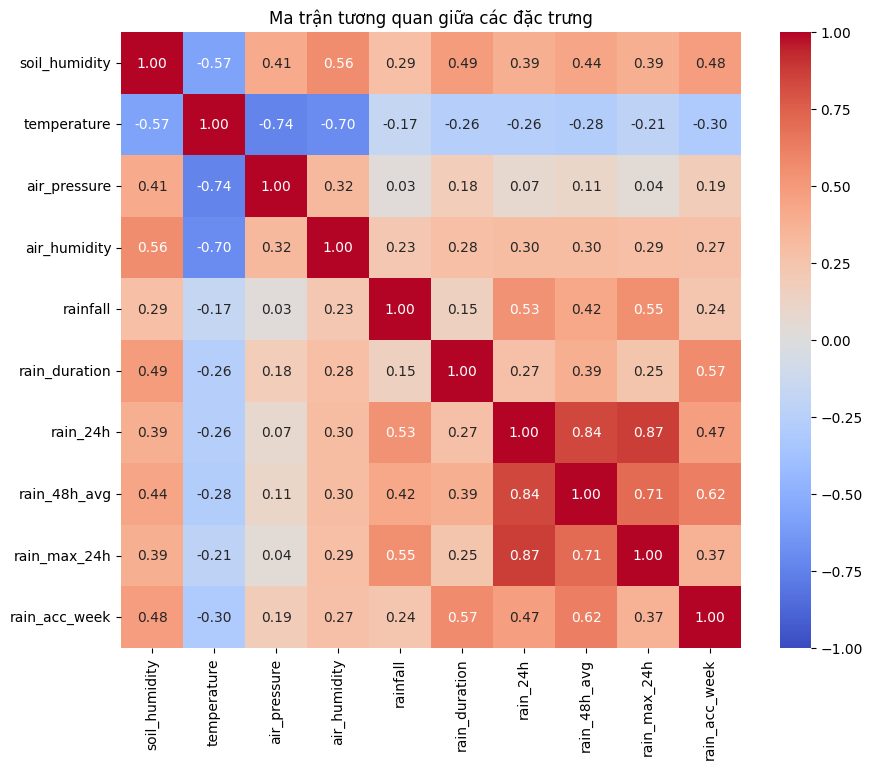

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, figsize=(10, 8)):
    """
    Vẽ ma trận tương quan giữa các đặc trưng.
    
    Parameters:
    -----------
    df : DataFrame - DataFrame chứa các đặc trưng số
    figsize : tuple - Kích thước biểu đồ
    """
    correlation_matrix = df.corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        vmin=-1, 
        vmax=1,
        square=True
    )
    plt.title("Ma trận tương quan giữa các đặc trưng", fontsize=14)
    plt.tight_layout()
    plt.show()

# Vẽ ma trận tương quan
plot_correlation_matrix(df)

---

## 9. Tổng kết

### Các đặc trưng cuối cùng:
| Đặc trưng | Mô tả | Đơn vị |
|-----------|-------|--------|
| `soil_humidity` | Độ ẩm đất | % |
| `temperature` | Nhiệt độ không khí | °C |
| `air_pressure` | Áp suất không khí | hPa |
| `air_humidity` | Độ ẩm không khí | % |
| `rainfall` | Lượng mưa theo giờ | mm |
| `rain_duration` | Thời gian mưa liên tục | giờ |
| `rain_24h` | Tổng lượng mưa 24 giờ | mm |
| `rain_48h_avg` | Lượng mưa trung bình 48 giờ | mm |
| `rain_max_24h` | Lượng mưa lớn nhất 24 giờ | mm |
| `rain_acc_week` | Tổng lượng mưa 7 ngày | mm |

### Các bước đã thực hiện:
1. ✅ Chuyển đổi file NetCDF sang CSV
2. ✅ Hợp nhất các file dữ liệu
3. ✅ Tính toán lượng mưa theo giờ
4. ✅ Tạo các đặc trưng liên quan đến mưa
5. ✅ Làm sạch và đổi tên cột
6. ✅ Phân tích tương quan giữa các đặc trưng

### File đầu ra:
- `data_train.csv` - Dữ liệu đã được xử lý và sẵn sàng cho mô hình học máy